In [43]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#To scale the data using z-score 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#To tune the model
from sklearn.model_selection import GridSearchCV

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

In [3]:
# loading datasets

train = pd.read_csv("game_train.csv")
test = pd.read_csv("game_test.csv")

In [27]:
target = 'user_suggestion'
X = train.drop([target], axis = 1)
y = train[target].values

In [29]:
from sklearn.model_selection import train_test_split
#Splitting the data into train and test sets
X_train,X_cv,y_train,y_cv=train_test_split(X, y, test_size=0.20, random_state=1 , stratify=y)

In [5]:
train.head()

,review_id,title,year,user_review,user_suggestion
0,473,Sakura Clicker,2017.0,This has helped me through my stage 8 terminal...,1
1,22971,Crusaders of the Lost Idols,2017.0,Awesome idea. I support this game. I love that...,1
2,18225,RaceRoom Racing Experience,2014.0,"This game is just, such a♥♥♥♥♥♥take. The devel...",0
3,17132,Black Squad,2018.0,Early Access Reviewhere what i honesty think a...,1
4,8103,DCS World Steam Edition,2014.0,Very detailed sim and a joy to fly using a fli...,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10494 entries, 0 to 10493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        10494 non-null  int64  
 1   title            10494 non-null  object 
 2   year             10386 non-null  float64
 3   user_review      10494 non-null  object 
 4   user_suggestion  10494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 410.0+ KB


In [31]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train["user_review"])
X_train_counts.shape

(8395, 35237)

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(8395, 35237)

In [33]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [34]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])

In [36]:
text_clf = text_clf.fit(X_train["user_review"], y_train)

In [38]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

           0       0.98      0.62      0.76      3606
           1       0.78      0.99      0.87      4789

    accuracy                           0.83      8395
   macro avg       0.88      0.80      0.81      8395
weighted avg       0.86      0.83      0.82      8395



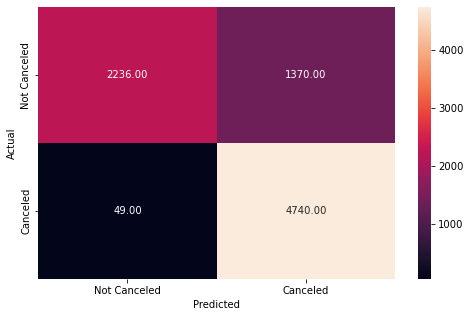

In [44]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
# Checking performance on the training data
y_pred_train = text_clf.predict(X_train["user_review"])
metrics_score(y_train,y_pred_train)

              precision    recall  f1-score   support

           0       0.92      0.44      0.60       902
           1       0.70      0.97      0.81      1197

    accuracy                           0.74      2099
   macro avg       0.81      0.71      0.70      2099
weighted avg       0.79      0.74      0.72      2099



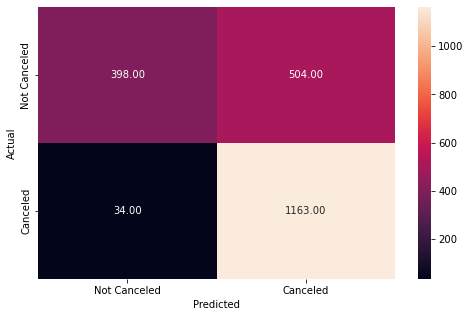

In [45]:
# Checking performance on the training data
y_pred_train = text_clf.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [47]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, random_state=42)),
])
_ = text_clf_svm.fit(X_train["user_review"], y_train)

              precision    recall  f1-score   support

           0       0.92      0.44      0.60       902
           1       0.70      0.97      0.81      1197

    accuracy                           0.74      2099
   macro avg       0.81      0.71      0.70      2099
weighted avg       0.79      0.74      0.72      2099



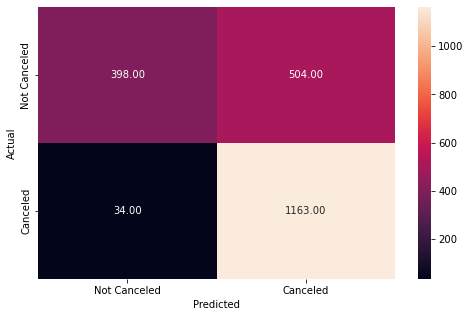

In [48]:
# Checking performance on the training data
y_pred_train = text_clf.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [49]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3),
}

In [50]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train["user_review"], y_train)

In [52]:
gs_clf.best_score_

0.8544371649791543

In [53]:
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       902
           1       0.85      0.91      0.87      1197

    accuracy                           0.85      2099
   macro avg       0.85      0.84      0.85      2099
weighted avg       0.85      0.85      0.85      2099



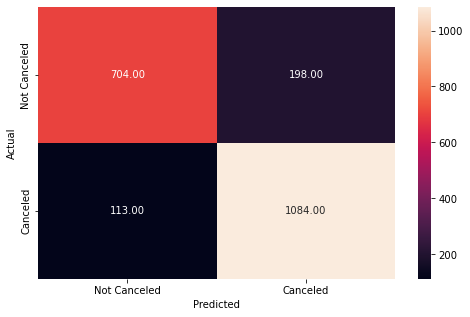

In [54]:
# Checking performance on the training data
y_pred_train = gs_clf.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [56]:
y_test_pred = gs_clf.predict(test["user_review"])
data = {'review_id' : test["review_id"],
       'user_suggestion' : y_test_pred}

pd.DataFrame(data).to_csv('predictions_5.csv', index = False)